In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

import matplotlib 
matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

In [3]:
from sklearn.ensemble import RandomForestRegressor
## visualize one of the tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
import os
os.environ['PATH'] = os.environ['PATH']+';'+os.environ['CONDA_PREFIX']+r"\Library\bin\graphviz"

In [4]:
from sklearn.linear_model import (LinearRegression, Ridge, Lasso, LassoCV)

In [5]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

In [6]:
## hyper parameter tuning
from sklearn.model_selection import RandomizedSearchCV
tuning = {
    'max_depth': [7,10,13,15,17],
    'max_features': [5,7,10,15,20,30],
    'min_samples_split': [2,5,7,10],
    'n_estimators': [10,30,50,70]
}

In [7]:
import Utils
importlib.reload(Utils) ## update the Utils library

<module 'Utils' from 'C:\\Users\\CSY\\Desktop\\potato-lankau\\scripts\\Utils.py'>

In [8]:
import ML_model as ml
importlib.reload(ml)

<module 'ML_model' from 'C:\\Users\\CSY\\Desktop\\potato-lankau\\scripts\\ML_model.py'>

In [9]:
meta = pd.read_csv("..//data//potatometadata_forClaudia.csv")
taxa = pd.read_csv("..//data//potatorar_forsubmission.csv")
taxa.columns.values[0] = "FieldID"
taxa = taxa.rename(columns = {'FieldID':'FieldID'})

In [10]:
meta_explore = meta[meta["Experiment"] == 2015]
meta_confirm = meta[meta["Experiment"] == 2017]

In [11]:
# drop non-numeric column
meta_clean = meta.drop(['field name', 'diffCSscore'], axis=1)
# In the new field, experiment conducted in 2015 is labeled as 0 whereas in 2017 as 1
meta_clean['Experiment'] = meta_clean['Experiment'].replace(2015, 0)
meta_clean['Experiment'] = meta_clean['Experiment'].replace(2017, 1)
# drop all column related to yield
yld_list = ['Mean.Control.Microbe', 'Mean.LowN.Microbe', 'varCtub', 'varNtub', 'invVar_Ctub',
           'invVar_Ntub', 'Std.Err.Mean.Control.Microbe', 'Std.Err.Mean.LowN.Microbe', ]
disease_unwanted = ['varCSscore', 'invVar_Csscore', 'seCSscore']
meta_clean = meta_clean.drop(yld_list, axis=1)
meta_clean = meta_clean.drop(disease_unwanted, axis=1)
meta_clean_2 = meta_clean.set_index('FieldID')
meta_clean_2_unnormalized = meta_clean_2.copy()

In [12]:
yt_disease, gamma, eta, epsilon, lbda = Utils.johnson_transform(meta.diffCSscore)
trans_param = {gamma, eta, epsilon, lbda}

In [13]:
# Pay attention here. yt has the index of field id, whereas yt_disease is just a series of number starting at 0
yt = yt_disease.copy()
yt.index = meta_clean_2.index  
yt

FieldID
1     0.015142
2    -0.486763
3    -0.154928
4     1.195968
5     0.814400
6     0.303205
7     0.744778
8    -0.369501
9     1.312314
10    0.732274
11   -0.339759
12    0.279803
13    2.075431
27    1.424344
28    0.093800
29    0.326124
30   -0.409760
31   -0.252561
32   -1.605319
33   -1.605319
36   -0.230164
37    0.842071
38   -1.605319
40   -1.605319
41    0.142125
42   -1.605319
Name: diffCSscore, dtype: float64

In [14]:
taxa_clean = taxa.loc[:, (taxa != 0).any(axis=0)]  # drop columns contain only 0
taxa_clean_2 = taxa_clean.set_index('FieldID')
taxa_clean_2_unnormalized = taxa_clean_2.copy()

In [15]:
clean = pd.concat([meta_clean_2_unnormalized.drop(['Experiment'], axis=1), taxa_clean_2_unnormalized], axis=1)
total, mu_total, sd_total = Utils.normalization(clean)
total = pd.concat([meta_clean_2_unnormalized.Experiment, total], axis=1)

xtrain_d, xval_d, ytrain_d, yval_d = train_test_split(total, yt, test_size=0.2, random_state=1)

xtrain_meta_d = xtrain_d[meta_clean_2.columns]
xval_meta_d = xval_d[meta_clean_2.columns]
xtrain_taxa_d = pd.concat([xtrain_meta_d.Experiment, xtrain_d[taxa_clean_2.columns]], axis=1)
xval_taxa_d = pd.concat([xval_meta_d.Experiment, xval_d[taxa_clean_2.columns]], axis=1)

meta_and_yt = pd.concat([meta_clean_2, yt], axis=1)

meta_and_yt.columns.values[-1] = "transformed disease score"
# meta_and_yt = taxa.rename(columns = {'FieldID':'FieldID'})
meta_and_yt.head(2)

,Experiment,claderich0.1,cladediv0.1,claderich0.15,cladediv0.15,claderich0.2,cladediv0.2,claderich0.25,cladediv0.25,claderich0.3,...,claderich0.6,cladediv0.6,claderich0.7,cladediv0.7,claderich0.8,cladediv0.8,asvrich,asvdiv,PD,transformed disease score
FieldID,,,,,,,,,,,,,,,,,,,,,
1,0,22,2.276874,40,2.601291,69,2.899249,118,3.239466,167,...,339,4.887446,370,5.087528,395,5.226187,400,5.230529,31.699375,0.015142
2,0,20,2.206943,32,2.400265,51,2.768876,103,3.229995,161,...,321,4.898134,337,5.144046,354,5.209358,355,5.211097,26.603089,-0.486763


In [ ]:
print(mu_total['claderich0.25'], sd_total['claderich0.25'])

In [40]:
## without change this to DataFrame, the result will be a pd.Series, which change the size of it
xtrain_meta_lasso_d, xval_meta_lasso_d = pd.DataFrame(xtrain_meta_d['claderich0.25']), pd.DataFrame(xval_meta_d['claderich0.25'])
xtrain_meta_lasso_d.head(2)

,claderich0.25
FieldID,
33,-0.008407
36,0.592663


In [38]:
# xtrain_meta_lasso_d["x_rich25_exp"] = np.exp(xtrain_meta_lasso_d["claderich0.25"])
# xtrain_meta_lasso_d["x_rich25_poly2"] = xtrain_meta_lasso_d["claderich0.25"]**2

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

In [42]:
linear_meta_lasso1 = LinearRegression()
linear_meta_lasso_coef1, linear_meta_lasso_intercept1 = \
    ml.linear_fit(linear_meta_lasso1, xtrain_meta_lasso_d, ytrain_d, xval_meta_lasso_d, yval_d, trans_param=trans_param, fs=(4, 4))


Linear Regression Model Report
RMSE for training set: 0.18255864326462418
RMSE for validation set: 0.25445049706901857


In [43]:
linear_meta_lasso_coef1, linear_meta_lasso_intercept1

(array([-0.58709895]), -0.016717959122650436)

In [46]:
polynomial_features= PolynomialFeatures(degree=2)
xtrain_meta_lasso_d_poly = polynomial_features.fit_transform(xtrain_meta_lasso_d)
xtrain_val_lasso_d_poly = polynomial_features.fit_transform(xval_meta_lasso_d)

In [49]:
linear_meta_lasso_coef2, linear_meta_lasso_intercept2 = \
    ml.linear_fit(linear_meta_lasso1, xtrain_meta_lasso_d_poly, ytrain_d, xtrain_val_lasso_d_poly, yval_d, trans_param=trans_param, fs=(4, 4))


Linear Regression Model Report
RMSE for training set: 0.18211444572224
RMSE for validation set: 0.2572978810978879


In [32]:
def model_visualization(ax, coef, intercpt, x, y, transformed, title='', xlab='x', ylab='y', title_font=15, lab_font=15, 
                        xlim=None):
    line_x = np.linspace(min(x), max(x), 100)
    if transformed:
        line_y, lb = linear(line_x, coef, intercpt)
    else:
        line_y, lb = untransformed(line_x, coef, intercpt)
    ax.plot(line_x, line_y, '-m', label=lb)
    ax.scatter(x, y)
    if xlim is None:
        ax.set_xlim(min(min(x) - 0.4, 0))
    else:
        ax.set_xlim(xlim)
    ax.set_title(title, fontsize=title_font)
    ax.set_xlabel(xlab, fontsize=lab_font, color='#1C2833')
    ax.set_ylabel(ylab, fontsize=lab_font, color='#1C2833')
    ax.legend(loc='upper right')
    ax.grid()

In [20]:
def linear(linex, coef, intercpt):
    liney = coef*linex + intercpt
    if intercpt < 0:
        lb = 'y=%.3fx-%.3f'% (coef, -intercpt)
    else:
        lb = 'y=%.3fx+%.3f'% (coef, intercpt)
    return liney, lb

In [21]:
def untransformed(line_x, coef, intercpt):
    line_y = coef*line_x + intercpt
    line_y = Utils.johnson_inverse(line_y, gamma, eta, epsilon, lbda)
    b_ = intercpt - gamma
    if b_ > 0:
        lb = r'y=$%.3f*\sinh(\frac{%.3fx+%.3f}{%.3f})-%.3f$'% (lbda, coef, b_, eta, -epsilon)
    else:
        lb = r'y=$%.3f*\sinh(\frac{%.3fx-%.3f}{%.3f})-%.3f$'% (lbda, coef, -b_, eta, -epsilon)
    return line_y, lb

In [23]:
x_rich25 = total['claderich0.25']
x_rich25

FieldID
1    -0.379977
2    -0.543905
3    -0.489262
4    -0.784333
5    -0.838975
6    -0.729690
7    -1.057546
8    -0.675047
9    -0.445548
10   -0.904546
11   -0.817118
12   -1.024760
13   -0.653190
27    0.789376
28   -0.489262
29    0.450592
30   -0.379977
31    0.811234
32    1.663659
33   -0.008407
36    0.592663
37    0.188307
38    0.975162
40    1.412303
41    0.221093
42    3.117154
Name: claderich0.25, dtype: float64

In [29]:
# x_rich25_exp = np.exp(x_rich25)
# x_rich25_log = np.log(x_rich25)

C:\Users\CSY\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


In [34]:
yt_exp = np.exp(yt)

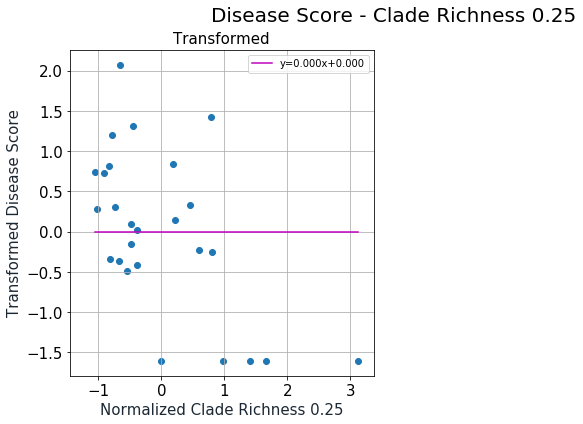

In [36]:
fig = plt.figure(figsize=(12, 6))
fig.suptitle("Disease Score - Clade Richness 0.25", fontsize=20)
ax1 = fig.add_subplot(1,2,1)
model_visualization(ax1, 0, 0, x_rich25, yt, transformed=True, title='Transformed', 
                    xlab='Normalized Clade Richness 0.25', ylab='Transformed Disease Score')